## Mutual information

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile

## Read Data

In [2]:
data = pd.read_csv('../UNSW_Train.csv')
data.shape

(175341, 44)

In [3]:
data.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack,is_intrusion
0,0.121478,113.0,0.0,2.0,6,4,258,172,74.087490,252,...,1,1,0,0,0,1,1,0,0,0
1,0.649902,113.0,0.0,2.0,14,38,734,42014,78.473372,62,...,1,2,0,0,0,1,6,0,0,0
2,1.623129,113.0,0.0,2.0,8,16,364,13186,14.170161,62,...,1,3,0,0,0,2,6,0,0,0
3,1.681642,113.0,3.0,2.0,12,12,628,770,13.677108,62,...,1,3,1,1,0,2,1,0,0,0
4,0.449454,113.0,0.0,2.0,10,6,534,268,33.373826,254,...,1,40,0,0,0,2,39,0,0,0


### Train - Test Split

In [4]:
# separate train and test sets

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['is_intrusion'], axis=1),
    data['is_intrusion'],
    test_size=0.2,
    random_state=0)

X_train.shape, X_test.shape

((140272, 43), (35069, 43))

### Determine Mutual Information

In [5]:
mi = mutual_info_classif(X_test, y_test) 
mi

array([3.28475327e-01, 1.21456594e-01, 3.70430580e-02, 1.70672536e-01,
       1.73850296e-01, 2.68066896e-01, 4.56747730e-01, 3.54559036e-01,
       3.38347178e-01, 3.73946221e-01, 3.43383019e-01, 3.33814053e-01,
       2.66840901e-01, 1.17823202e-01, 1.42896518e-01, 2.38681623e-01,
       2.88656988e-01, 1.95013713e-01, 1.71636981e-01, 5.54590366e-02,
       5.62743622e-02, 5.37605786e-02, 5.60633163e-02, 2.29331116e-01,
       2.31245909e-01, 2.27167888e-01, 3.35237441e-01, 3.01123330e-01,
       0.00000000e+00, 3.43053346e-02, 8.24261760e-02, 3.39293143e-01,
       1.13785241e-01, 9.07809545e-02, 1.36154784e-01, 9.26640576e-02,
       0.00000000e+00, 1.91018354e-04, 0.00000000e+00, 9.24922458e-02,
       9.57979388e-02, 2.14812584e-02, 6.30861381e-01])

Text(0, 0.5, 'Mutual Information')

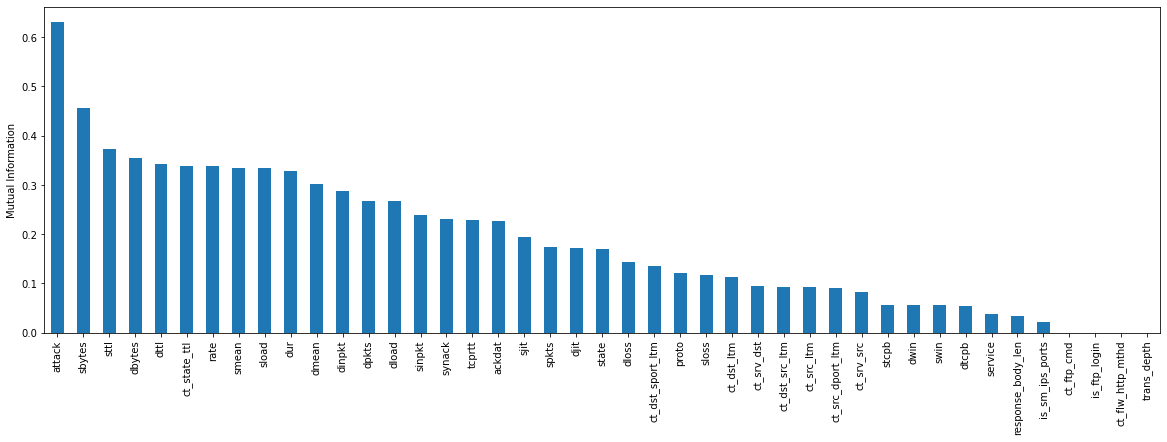

In [6]:
# 1. Let's capture the above array in a pandas series
# 2. Add the variable names in the index
# 3. Sort the features based on their mutual information value
# 4. And make a var plot

mi = pd.Series(mi)
mi.index = X_test.columns
mi.sort_values(ascending=False).plot.bar(figsize=(20, 6))
plt.ylabel('Mutual Information')

### Select top k features based on MI

In [7]:
# select the top 15 features based on their mutual information value
sel_ = SelectKBest(mutual_info_classif, k=15).fit(X_test, y_test)

# display features
X_test.columns[sel_.get_support()]

Index(['dur', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload',
       'dload', 'sinpkt', 'dinpkt', 'smean', 'dmean', 'ct_state_ttl',
       'attack'],
      dtype='object')

In [8]:
# to remove the rest of the features:

X_train = sel_.transform(X_train)
X_test = sel_.transform(X_test)

In [9]:
X_train.shape, X_test.shape

((140272, 15), (35069, 15))

## Standardize Data


In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

## Classifiers

In [11]:
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

## Metrics Evaluation

In [12]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, f1_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score

### Logistic Regression

In [13]:
%%time
clf_LR = linear_model.LogisticRegression(n_jobs=-1, random_state=42, C=25).fit(X_train, y_train)

CPU times: user 76.1 ms, sys: 197 ms, total: 273 ms
Wall time: 1.95 s


In [14]:
pred_y_test = clf_LR.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_test))

f1 = f1_score(y_test, pred_y_test)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_test)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.3403005503436083
F1 Score: 0.06279116872594694
FPR: 0.007736083940956784
TPR: 0.032531587121689125


### Naive Bayes

In [15]:
%%time
clf_NB = GaussianNB(var_smoothing=1e-08).fit(X_train, y_train)

CPU times: user 42.1 ms, sys: 10.1 ms, total: 52.1 ms
Wall time: 50.4 ms


In [16]:
pred_y_testNB = clf_NB.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_testNB))

f1 = f1_score(y_test, pred_y_testNB)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testNB)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.7638940374689897
F1 Score: 0.8035680394761815
FPR: 0.12386626356037703
TPR: 0.7109096251521638


### Random Forest


In [17]:
%%time
clf_RF = RandomForestClassifier(random_state=0,max_depth=100,n_estimators=1000).fit(X_train, y_train)

CPU times: user 50 s, sys: 679 ms, total: 50.7 s
Wall time: 50.7 s


In [18]:
pred_y_testRF = clf_RF.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_testRF))

f1 = f1_score(y_test, pred_y_testRF, average='weighted', zero_division=0)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testRF)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.6793179161082438
F1 Score: 0.5495955550990522
FPR: 1.0
TPR: 1.0


### KNN

In [19]:
%%time
clf_KNN = KNeighborsClassifier(algorithm='ball_tree',leaf_size=1,n_neighbors=5,weights='uniform').fit(X_train, y_train)

CPU times: user 6.47 s, sys: 40.5 ms, total: 6.51 s
Wall time: 6.48 s


In [20]:
pred_y_testKNN = clf_KNN.predict(X_test)
print('accuracy_score:', accuracy_score(y_test, pred_y_testKNN))

f1 = f1_score(y_test, pred_y_testKNN)
print('f1:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testKNN)
print('fpr:', fpr[1])
print('tpr:', tpr[1])

accuracy_score: 0.7429068407995666
f1: 0.8377366640270678
fpr: 0.7528899164147252
tpr: 0.9769550434454098


### CatBoost

In [21]:
%%time
clf_CB = CatBoostClassifier(random_state=0,depth=7,iterations=50,learning_rate=0.04).fit(X_train, y_train)

0:	learn: 0.6539535	total: 64.2ms	remaining: 3.15s
1:	learn: 0.6177720	total: 69.1ms	remaining: 1.66s
2:	learn: 0.5842853	total: 76.1ms	remaining: 1.19s
3:	learn: 0.5532671	total: 85.9ms	remaining: 988ms
4:	learn: 0.5243632	total: 95.4ms	remaining: 859ms
5:	learn: 0.4974323	total: 104ms	remaining: 764ms
6:	learn: 0.4722391	total: 113ms	remaining: 695ms
7:	learn: 0.4485890	total: 120ms	remaining: 629ms
8:	learn: 0.4264570	total: 129ms	remaining: 588ms
9:	learn: 0.4056514	total: 139ms	remaining: 554ms
10:	learn: 0.3860523	total: 146ms	remaining: 518ms
11:	learn: 0.3676140	total: 155ms	remaining: 492ms
12:	learn: 0.3502077	total: 162ms	remaining: 462ms
13:	learn: 0.3337846	total: 169ms	remaining: 435ms
14:	learn: 0.3182790	total: 178ms	remaining: 414ms
15:	learn: 0.3036198	total: 186ms	remaining: 394ms
16:	learn: 0.2897599	total: 194ms	remaining: 377ms
17:	learn: 0.2765851	total: 199ms	remaining: 354ms
18:	learn: 0.2641292	total: 208ms	remaining: 339ms
19:	learn: 0.2523268	total: 216ms	re

In [22]:
pred_y_testCB = clf_CB.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_testCB))

f1 = f1_score(y_test, pred_y_testCB, average='weighted', zero_division=0)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testCB)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.6793179161082438
F1 Score: 0.5495955550990522
FPR: 1.0
TPR: 1.0


## Model Evaluation


In [3]:
data = pd.read_csv('../UNSW_Test.csv')
data.shape

(175341, 44)

In [4]:
# Create feature matrix X and target vextor y
y_eval = data['is_intrusion']
X_eval = data.drop(columns=['is_intrusion'])

In [5]:
X_eval = sel_.transform(X_eval)

NameError: name 'sel_' is not defined

In [6]:
X_eval.shape

(175341, 43)

### Model Evaluation - Logistic Regression



In [30]:
modelLR = linear_model.LogisticRegression(n_jobs=-1, random_state=42, C=25)
modelLR.fit(X_train, y_train)

LogisticRegression(C=25, n_jobs=-1, random_state=42)

In [31]:
# Predict on the new unseen test data
y_evalpredLR = modelLR.predict(X_eval)
y_predLR = modelLR.predict(X_test)

In [32]:
train_scoreLR = modelLR.score(X_train, y_train)
test_scoreLR = modelLR.score(X_test, y_test)
print("Training accuracy is ", train_scoreLR)
print("Testing accuracy is ", test_scoreLR)

Training accuracy is  1.0
Testing accuracy is  0.3403005503436083


In [33]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreLR)
print('F1 Score:',f1_score(y_test, y_predLR))
print('Precision Score:',precision_score(y_test, y_predLR))
print('Recall Score:', recall_score(y_test, y_predLR))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predLR))

Performance measures for test:
--------
Accuracy: 0.3403005503436083
F1 Score: 0.06279116872594694
Precision Score: 0.8990719257540604
Recall Score: 0.032531587121689125
Confusion Matrix:
 [[11159    87]
 [23048   775]]


### Cross validation - Logistic Regression




In [34]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.82946 (+/- 0.08625)
F1 Score: 0.87260 (+/- 0.05482)
Precision: 0.90156 (+/- 0.14756)
Recall: 0.85509 (+/- 0.13450)


### Model Evaluation - Naive Bayes





In [35]:
modelNB = GaussianNB(var_smoothing=1e-08)
modelNB.fit(X_train, y_train)

GaussianNB(var_smoothing=1e-08)

In [36]:
# Predict on the new unseen test data
y_evalpredNB = modelNB.predict(X_eval)
y_predNB = modelNB.predict(X_test)

In [37]:
train_scoreNB = modelNB.score(X_train, y_train)
test_scoreNB = modelNB.score(X_test, y_test)
print("Training accuracy is ", train_scoreNB)
print("Testing accuracy is ", test_scoreNB)

Training accuracy is  1.0
Testing accuracy is  0.7638940374689897


In [38]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreNB)
print('F1 Score:',f1_score(y_test, y_predNB))
print('Precision Score:',precision_score(y_test, y_predNB))
print('Recall Score:', recall_score(y_test, y_predNB))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predNB))

Performance measures for test:
--------
Accuracy: 0.7638940374689897
F1 Score: 0.8035680394761815
Precision Score: 0.9240002182334006
Recall Score: 0.7109096251521638
Confusion Matrix:
 [[ 9853  1393]
 [ 6887 16936]]


### Cross validation - Naive Bayes



In [39]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.83509 (+/- 0.17800)
F1 Score: 0.89274 (+/- 0.09849)
Precision: 0.82846 (+/- 0.17068)
Recall: 0.97471 (+/- 0.02269)


### Model Evaluation - Random Forest



In [40]:
modelRF = RandomForestClassifier(random_state=0,max_depth=100,n_estimators=1000)
modelRF.fit(X_train, y_train)

RandomForestClassifier(max_depth=100, n_estimators=1000, random_state=0)

In [41]:
# Predict on the new unseen test data
y_evalpredRF = modelRF.predict(X_eval)
y_predRF = modelRF.predict(X_test)

In [42]:
train_scoreRF = modelRF.score(X_train, y_train)
test_scoreRF = modelRF.score(X_test, y_test)
print("Training accuracy is ", train_scoreRF)
print("Testing accuracy is ", test_scoreRF)

Training accuracy is  1.0
Testing accuracy is  0.6793179161082438


In [43]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreRF)
print('F1 Score:', f1_score(y_test, y_predRF, average='weighted', zero_division=0))
print('Precision Score:', precision_score(y_test, y_predRF, average='weighted', zero_division=0))
print('Recall Score:', recall_score(y_test, y_predRF, average='weighted', zero_division=0))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predRF))

Performance measures for test:
--------
Accuracy: 0.6793179161082438
F1 Score: 0.5495955550990522
Precision Score: 0.4614728311456469
Recall Score: 0.6793179161082438
Confusion Matrix:
 [[    0 11246]
 [    0 23823]]


### Cross validation - Random Forest



In [44]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 1.00000 (+/- 0.00000)
F1 Score: 1.00000 (+/- 0.00000)
Precision: 1.00000 (+/- 0.00000)
Recall: 1.00000 (+/- 0.00000)


### Model Evaluation - KNN

In [45]:
modelKNN = KNeighborsClassifier(algorithm='ball_tree',leaf_size=1,n_neighbors=5,weights='uniform')
modelKNN.fit(X_train, y_train)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=1)

In [46]:
# Predict on the new unseen test data
y_evalpredKNN = modelKNN.predict(X_eval)
y_predKNN = modelKNN.predict(X_test)

In [47]:
train_scoreKNN = modelKNN.score(X_train, y_train)
test_scoreKNN = modelKNN.score(X_test, y_test)
print("Training accuracy is ", train_scoreKNN)
print("Testing accuracy is ", test_scoreKNN)

Training accuracy is  0.9999215809284818
Testing accuracy is  0.7429068407995666


In [48]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreKNN)
print('F1 Score:', f1_score(y_test, y_predKNN))
print('Precision Score:', precision_score(y_test, y_predKNN))
print('Recall Score:', recall_score(y_test, y_predKNN))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predKNN))

Performance measures for test:
--------
Accuracy: 0.7429068407995666
F1 Score: 0.8377366640270678
Precision Score: 0.7332472196843199
Recall Score: 0.9769550434454098
Confusion Matrix:
 [[ 2779  8467]
 [  549 23274]]


### Cross validation - KNN



In [49]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.91888 (+/- 0.09863)
F1 Score: 0.94287 (+/- 0.06320)
Precision: 0.93307 (+/- 0.14255)
Recall: 0.95747 (+/- 0.05023)


### Model Evaluation - CatBoost

In [50]:
modelCB = CatBoostClassifier(random_state=0,depth=7,iterations=50,learning_rate=0.04)
modelCB.fit(X_train, y_train)

0:	learn: 0.6539535	total: 5.55ms	remaining: 272ms
1:	learn: 0.6177720	total: 10.3ms	remaining: 247ms
2:	learn: 0.5842853	total: 16.2ms	remaining: 253ms
3:	learn: 0.5532671	total: 24.9ms	remaining: 286ms
4:	learn: 0.5243632	total: 33.5ms	remaining: 302ms
5:	learn: 0.4974323	total: 42.8ms	remaining: 314ms
6:	learn: 0.4722391	total: 51.5ms	remaining: 316ms
7:	learn: 0.4485890	total: 57.5ms	remaining: 302ms
8:	learn: 0.4264570	total: 65.7ms	remaining: 299ms
9:	learn: 0.4056514	total: 73.9ms	remaining: 295ms
10:	learn: 0.3860523	total: 80.1ms	remaining: 284ms
11:	learn: 0.3676140	total: 88.8ms	remaining: 281ms
12:	learn: 0.3502077	total: 95.3ms	remaining: 271ms
13:	learn: 0.3337846	total: 102ms	remaining: 261ms
14:	learn: 0.3182790	total: 110ms	remaining: 256ms
15:	learn: 0.3036198	total: 118ms	remaining: 252ms
16:	learn: 0.2897599	total: 127ms	remaining: 246ms
17:	learn: 0.2765851	total: 132ms	remaining: 235ms
18:	learn: 0.2641292	total: 140ms	remaining: 229ms
19:	learn: 0.2523268	total: 

In [51]:
# Predict on the new unseen test data
y_evalpredCB = modelCB.predict(X_eval)
y_predCB = modelCB.predict(X_test)

In [52]:
train_scoreCB = modelCB.score(X_train, y_train)
test_scoreCB = modelCB.score(X_test, y_test)
print("Training accuracy is ", train_scoreCB)
print("Testing accuracy is ", test_scoreCB)

Training accuracy is  1.0
Testing accuracy is  0.6793179161082438


In [53]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreCB)
print('F1 Score:',f1_score(y_test, y_predCB, average='weighted', zero_division=0))
print('Precision Score:',precision_score(y_test, y_predCB, average='weighted', zero_division=0))
print('Recall Score:', recall_score(y_test, y_predCB, average='weighted', zero_division=0))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predCB))

Performance measures for test:
--------
Accuracy: 0.6793179161082438
F1 Score: 0.5495955550990522
Precision Score: 0.4614728311456469
Recall Score: 0.6793179161082438
Confusion Matrix:
 [[    0 11246]
 [    0 23823]]


### Cross validation - CatBoost

In [54]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='accuracy')
f = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='f1')
precision = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='precision')
recall = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='recall')

0:	learn: 0.6539528	total: 6.32ms	remaining: 310ms
1:	learn: 0.6177707	total: 11.5ms	remaining: 275ms
2:	learn: 0.5842815	total: 18.3ms	remaining: 286ms
3:	learn: 0.5532538	total: 27.1ms	remaining: 311ms
4:	learn: 0.5243420	total: 36.2ms	remaining: 326ms
5:	learn: 0.4974026	total: 45.3ms	remaining: 332ms
6:	learn: 0.4722047	total: 54.6ms	remaining: 336ms
7:	learn: 0.4485551	total: 61.8ms	remaining: 325ms
8:	learn: 0.4264184	total: 70.9ms	remaining: 323ms
9:	learn: 0.4056106	total: 79.8ms	remaining: 319ms
10:	learn: 0.3860123	total: 86.5ms	remaining: 307ms
11:	learn: 0.3675728	total: 95.9ms	remaining: 304ms
12:	learn: 0.3501676	total: 103ms	remaining: 292ms
13:	learn: 0.3337449	total: 109ms	remaining: 281ms
14:	learn: 0.3182385	total: 118ms	remaining: 275ms
15:	learn: 0.3035780	total: 127ms	remaining: 270ms
16:	learn: 0.2897160	total: 136ms	remaining: 265ms
17:	learn: 0.2765431	total: 142ms	remaining: 252ms
18:	learn: 0.2640846	total: 150ms	remaining: 245ms
19:	learn: 0.2522794	total: 1

25:	learn: 0.1927294	total: 206ms	remaining: 190ms
26:	learn: 0.1844222	total: 216ms	remaining: 184ms
27:	learn: 0.1765126	total: 225ms	remaining: 177ms
28:	learn: 0.1689641	total: 234ms	remaining: 170ms
29:	learn: 0.1617776	total: 244ms	remaining: 162ms
30:	learn: 0.1549316	total: 253ms	remaining: 155ms
31:	learn: 0.1483767	total: 262ms	remaining: 148ms
32:	learn: 0.1421237	total: 271ms	remaining: 140ms
33:	learn: 0.1361675	total: 281ms	remaining: 132ms
34:	learn: 0.1304835	total: 291ms	remaining: 125ms
35:	learn: 0.1250538	total: 301ms	remaining: 117ms
36:	learn: 0.1198628	total: 310ms	remaining: 109ms
37:	learn: 0.1148733	total: 316ms	remaining: 99.7ms
38:	learn: 0.1101301	total: 326ms	remaining: 91.9ms
39:	learn: 0.1055775	total: 333ms	remaining: 83.3ms
40:	learn: 0.1012316	total: 342ms	remaining: 75.1ms
41:	learn: 0.0970860	total: 351ms	remaining: 66.8ms
42:	learn: 0.0931165	total: 360ms	remaining: 58.6ms
43:	learn: 0.0893262	total: 369ms	remaining: 50.4ms
44:	learn: 0.0856817	tot

49:	learn: 0.0696188	total: 404ms	remaining: 0us
0:	learn: 0.6539528	total: 5.54ms	remaining: 271ms
1:	learn: 0.6177707	total: 12.1ms	remaining: 291ms
2:	learn: 0.5842815	total: 18.9ms	remaining: 295ms
3:	learn: 0.5532540	total: 28.2ms	remaining: 324ms
4:	learn: 0.5243460	total: 37.2ms	remaining: 335ms
5:	learn: 0.4974073	total: 46.4ms	remaining: 340ms
6:	learn: 0.4722092	total: 55.7ms	remaining: 342ms
7:	learn: 0.4485595	total: 62.5ms	remaining: 328ms
8:	learn: 0.4264261	total: 71.6ms	remaining: 326ms
9:	learn: 0.4056179	total: 80.4ms	remaining: 322ms
10:	learn: 0.3860192	total: 87.1ms	remaining: 309ms
11:	learn: 0.3675794	total: 96.7ms	remaining: 306ms
12:	learn: 0.3501736	total: 105ms	remaining: 297ms
13:	learn: 0.3337505	total: 112ms	remaining: 287ms
14:	learn: 0.3182437	total: 120ms	remaining: 281ms
15:	learn: 0.3035827	total: 130ms	remaining: 275ms
16:	learn: 0.2897189	total: 139ms	remaining: 269ms
17:	learn: 0.2765459	total: 144ms	remaining: 256ms
18:	learn: 0.2640887	total: 153

24:	learn: 0.2014600	total: 200ms	remaining: 200ms
25:	learn: 0.1927374	total: 209ms	remaining: 193ms
26:	learn: 0.1844074	total: 215ms	remaining: 183ms
27:	learn: 0.1764782	total: 222ms	remaining: 174ms
28:	learn: 0.1689413	total: 231ms	remaining: 167ms
29:	learn: 0.1617539	total: 240ms	remaining: 160ms
30:	learn: 0.1548947	total: 248ms	remaining: 152ms
31:	learn: 0.1483554	total: 257ms	remaining: 145ms
32:	learn: 0.1421183	total: 266ms	remaining: 137ms
33:	learn: 0.1361548	total: 276ms	remaining: 130ms
34:	learn: 0.1304377	total: 281ms	remaining: 120ms
35:	learn: 0.1249857	total: 288ms	remaining: 112ms
36:	learn: 0.1197926	total: 297ms	remaining: 104ms
37:	learn: 0.1148310	total: 306ms	remaining: 96.7ms
38:	learn: 0.1100617	total: 312ms	remaining: 88ms
39:	learn: 0.1055122	total: 320ms	remaining: 80.1ms
40:	learn: 0.1011635	total: 329ms	remaining: 72.3ms
41:	learn: 0.0970202	total: 339ms	remaining: 64.5ms
42:	learn: 0.0930409	total: 348ms	remaining: 56.6ms
43:	learn: 0.0892194	total:

47:	learn: 0.0756671	total: 401ms	remaining: 16.7ms
48:	learn: 0.0726167	total: 410ms	remaining: 8.38ms
49:	learn: 0.0696976	total: 420ms	remaining: 0us
0:	learn: 0.6539528	total: 5.58ms	remaining: 274ms
1:	learn: 0.6177707	total: 10.9ms	remaining: 262ms
2:	learn: 0.5842815	total: 17.4ms	remaining: 272ms
3:	learn: 0.5532537	total: 26.4ms	remaining: 304ms
4:	learn: 0.5243439	total: 35.7ms	remaining: 322ms
5:	learn: 0.4974060	total: 45.3ms	remaining: 332ms
6:	learn: 0.4722081	total: 54.4ms	remaining: 334ms
7:	learn: 0.4485585	total: 61.1ms	remaining: 321ms
8:	learn: 0.4264236	total: 69.8ms	remaining: 318ms
9:	learn: 0.4056156	total: 78.4ms	remaining: 314ms
10:	learn: 0.3860170	total: 85ms	remaining: 301ms
11:	learn: 0.3675770	total: 95.6ms	remaining: 303ms
12:	learn: 0.3501714	total: 102ms	remaining: 291ms
13:	learn: 0.3337485	total: 111ms	remaining: 285ms
14:	learn: 0.3182433	total: 120ms	remaining: 279ms
15:	learn: 0.3035828	total: 129ms	remaining: 274ms
16:	learn: 0.2897205	total: 138

24:	learn: 0.2014619	total: 202ms	remaining: 202ms
25:	learn: 0.1927391	total: 211ms	remaining: 195ms
26:	learn: 0.1844090	total: 218ms	remaining: 185ms
27:	learn: 0.1764804	total: 225ms	remaining: 177ms
28:	learn: 0.1689434	total: 234ms	remaining: 169ms
29:	learn: 0.1617561	total: 243ms	remaining: 162ms
30:	learn: 0.1548975	total: 250ms	remaining: 154ms
31:	learn: 0.1483583	total: 260ms	remaining: 146ms
32:	learn: 0.1421216	total: 269ms	remaining: 138ms
33:	learn: 0.1361575	total: 278ms	remaining: 131ms
34:	learn: 0.1304403	total: 283ms	remaining: 121ms
35:	learn: 0.1249880	total: 290ms	remaining: 113ms
36:	learn: 0.1197954	total: 299ms	remaining: 105ms
37:	learn: 0.1148339	total: 308ms	remaining: 97.3ms
38:	learn: 0.1100645	total: 314ms	remaining: 88.5ms
39:	learn: 0.1055152	total: 321ms	remaining: 80.4ms
40:	learn: 0.1011665	total: 330ms	remaining: 72.4ms
41:	learn: 0.0970258	total: 339ms	remaining: 64.5ms
42:	learn: 0.0930463	total: 348ms	remaining: 56.6ms
43:	learn: 0.0892246	tota

48:	learn: 0.0725303	total: 394ms	remaining: 8.05ms
49:	learn: 0.0696130	total: 404ms	remaining: 0us
0:	learn: 0.6539528	total: 7.27ms	remaining: 356ms
1:	learn: 0.6177707	total: 12.6ms	remaining: 302ms
2:	learn: 0.5842815	total: 18.8ms	remaining: 295ms
3:	learn: 0.5532546	total: 27.5ms	remaining: 316ms
4:	learn: 0.5243434	total: 36.5ms	remaining: 328ms
5:	learn: 0.4974066	total: 45.7ms	remaining: 335ms
6:	learn: 0.4722081	total: 55ms	remaining: 338ms
7:	learn: 0.4485585	total: 61.9ms	remaining: 325ms
8:	learn: 0.4264236	total: 70.6ms	remaining: 322ms
9:	learn: 0.4056153	total: 79.8ms	remaining: 319ms
10:	learn: 0.3860167	total: 86.6ms	remaining: 307ms
11:	learn: 0.3675767	total: 95.8ms	remaining: 303ms
12:	learn: 0.3501712	total: 103ms	remaining: 293ms
13:	learn: 0.3337483	total: 110ms	remaining: 283ms
14:	learn: 0.3182437	total: 119ms	remaining: 277ms
15:	learn: 0.3035827	total: 127ms	remaining: 271ms
16:	learn: 0.2897194	total: 136ms	remaining: 265ms
17:	learn: 0.2765463	total: 142m

24:	learn: 0.2014639	total: 201ms	remaining: 201ms
25:	learn: 0.1927407	total: 210ms	remaining: 193ms
26:	learn: 0.1844105	total: 215ms	remaining: 184ms
27:	learn: 0.1764809	total: 223ms	remaining: 175ms
28:	learn: 0.1689444	total: 232ms	remaining: 168ms
29:	learn: 0.1617554	total: 241ms	remaining: 161ms
30:	learn: 0.1548966	total: 249ms	remaining: 153ms
31:	learn: 0.1483570	total: 260ms	remaining: 146ms
32:	learn: 0.1421204	total: 270ms	remaining: 139ms
33:	learn: 0.1361559	total: 279ms	remaining: 131ms
34:	learn: 0.1304388	total: 285ms	remaining: 122ms
35:	learn: 0.1249867	total: 291ms	remaining: 113ms
36:	learn: 0.1197941	total: 300ms	remaining: 105ms
37:	learn: 0.1148326	total: 309ms	remaining: 97.7ms
38:	learn: 0.1100633	total: 315ms	remaining: 88.9ms
39:	learn: 0.1055140	total: 323ms	remaining: 80.7ms
40:	learn: 0.1011652	total: 331ms	remaining: 72.7ms
41:	learn: 0.0970231	total: 340ms	remaining: 64.7ms
42:	learn: 0.0930438	total: 349ms	remaining: 56.8ms
43:	learn: 0.0892222	tota

48:	learn: 0.0725360	total: 408ms	remaining: 8.32ms
49:	learn: 0.0696195	total: 417ms	remaining: 0us
0:	learn: 0.6539528	total: 5.15ms	remaining: 252ms
1:	learn: 0.6177707	total: 10.1ms	remaining: 241ms
2:	learn: 0.5842815	total: 16.5ms	remaining: 259ms
3:	learn: 0.5532501	total: 25.6ms	remaining: 295ms
4:	learn: 0.5243393	total: 34.7ms	remaining: 312ms
5:	learn: 0.4974000	total: 43.6ms	remaining: 320ms
6:	learn: 0.4722013	total: 53.2ms	remaining: 327ms
7:	learn: 0.4485521	total: 60.1ms	remaining: 315ms
8:	learn: 0.4264162	total: 69.2ms	remaining: 315ms
9:	learn: 0.4056066	total: 78.1ms	remaining: 312ms
10:	learn: 0.3860085	total: 84.9ms	remaining: 301ms
11:	learn: 0.3675693	total: 94.1ms	remaining: 298ms
12:	learn: 0.3501642	total: 102ms	remaining: 291ms
13:	learn: 0.3337410	total: 109ms	remaining: 281ms
14:	learn: 0.3182345	total: 118ms	remaining: 276ms
15:	learn: 0.3035745	total: 127ms	remaining: 271ms
16:	learn: 0.2897103	total: 137ms	remaining: 265ms
17:	learn: 0.2765377	total: 14

25:	learn: 0.1927403	total: 207ms	remaining: 191ms
26:	learn: 0.1844102	total: 213ms	remaining: 182ms
27:	learn: 0.1764815	total: 221ms	remaining: 173ms
28:	learn: 0.1689450	total: 230ms	remaining: 166ms
29:	learn: 0.1617582	total: 239ms	remaining: 159ms
30:	learn: 0.1549000	total: 248ms	remaining: 152ms
31:	learn: 0.1483606	total: 257ms	remaining: 145ms
32:	learn: 0.1421241	total: 266ms	remaining: 137ms
33:	learn: 0.1361606	total: 275ms	remaining: 130ms
34:	learn: 0.1304432	total: 281ms	remaining: 120ms
35:	learn: 0.1249908	total: 287ms	remaining: 112ms
36:	learn: 0.1197981	total: 296ms	remaining: 104ms
37:	learn: 0.1148366	total: 305ms	remaining: 96.4ms
38:	learn: 0.1100671	total: 311ms	remaining: 87.8ms
39:	learn: 0.1055181	total: 319ms	remaining: 79.8ms
40:	learn: 0.1011691	total: 328ms	remaining: 72ms
41:	learn: 0.0970279	total: 337ms	remaining: 64.2ms
42:	learn: 0.0930481	total: 346ms	remaining: 56.3ms
43:	learn: 0.0892263	total: 352ms	remaining: 48.1ms
44:	learn: 0.0856175	total

49:	learn: 0.0696176	total: 401ms	remaining: 0us
0:	learn: 0.6539528	total: 5.35ms	remaining: 262ms
1:	learn: 0.6177707	total: 10.7ms	remaining: 257ms
2:	learn: 0.5842815	total: 17.2ms	remaining: 270ms
3:	learn: 0.5532520	total: 25.9ms	remaining: 298ms
4:	learn: 0.5243424	total: 35.8ms	remaining: 322ms
5:	learn: 0.4974047	total: 44.9ms	remaining: 329ms
6:	learn: 0.4722065	total: 54.2ms	remaining: 333ms
7:	learn: 0.4485570	total: 61.1ms	remaining: 321ms
8:	learn: 0.4264233	total: 70ms	remaining: 319ms
9:	learn: 0.4056155	total: 78.7ms	remaining: 315ms
10:	learn: 0.3860169	total: 85.5ms	remaining: 303ms
11:	learn: 0.3675770	total: 94.6ms	remaining: 300ms
12:	learn: 0.3501714	total: 102ms	remaining: 289ms
13:	learn: 0.3337485	total: 109ms	remaining: 280ms
14:	learn: 0.3182441	total: 118ms	remaining: 274ms
15:	learn: 0.3035831	total: 127ms	remaining: 269ms
16:	learn: 0.2897205	total: 136ms	remaining: 264ms
17:	learn: 0.2765474	total: 141ms	remaining: 251ms
18:	learn: 0.2640902	total: 150ms

24:	learn: 0.2014531	total: 202ms	remaining: 202ms
25:	learn: 0.1927306	total: 211ms	remaining: 195ms
26:	learn: 0.1844009	total: 216ms	remaining: 184ms
27:	learn: 0.1764717	total: 225ms	remaining: 177ms
28:	learn: 0.1689344	total: 234ms	remaining: 170ms
29:	learn: 0.1617468	total: 243ms	remaining: 162ms
30:	learn: 0.1548884	total: 251ms	remaining: 154ms
31:	learn: 0.1483493	total: 261ms	remaining: 147ms
32:	learn: 0.1421124	total: 270ms	remaining: 139ms
33:	learn: 0.1361489	total: 279ms	remaining: 131ms
34:	learn: 0.1304321	total: 284ms	remaining: 122ms
35:	learn: 0.1249803	total: 291ms	remaining: 113ms
36:	learn: 0.1197874	total: 300ms	remaining: 105ms
37:	learn: 0.1148257	total: 309ms	remaining: 97.5ms
38:	learn: 0.1100567	total: 315ms	remaining: 88.7ms
39:	learn: 0.1055075	total: 322ms	remaining: 80.5ms
40:	learn: 0.1011589	total: 330ms	remaining: 72.5ms
41:	learn: 0.0970153	total: 339ms	remaining: 64.6ms
42:	learn: 0.0930360	total: 348ms	remaining: 56.7ms
43:	learn: 0.0892148	tota

In [55]:
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 1.00000 (+/- 0.00000)
F1 Score: 1.00000 (+/- 0.00000)
Precision: 1.00000 (+/- 0.00000)
Recall: 1.00000 (+/- 0.00000)
